In [1]:
import pandas as pd
import re
import nltk
import itertools

# Preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# Building classification models
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Model evaluation
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score

pd.set_option('display.max_colwidth', None)

In [2]:
train_path = 'cards_data/training/training.csv'
valid_path = 'cards_data/training/validation.csv'
test_path = 'cards_data/training/test.csv'

train_df = pd.read_csv(train_path)
valid_df = pd.read_csv(valid_path)
test_df = pd.read_csv(test_path)

In [3]:
new = train_df['claim'].str.split("_", n = 1, expand = True)
train_df['super_claim'] = new[0]
train_df['sub_claim'] = new[1]

In [4]:
train_df.head()

text  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 What do you do if you are a global warming alarmist and real-world temperatures do not warm as much as your climate model predicted?   
1                                                                                                                                                                                                                                                                                                                                                                                                                              (2.) A sun-blocking volcanic aerosols component to explain the sudden but temporary cooling of global sea surface temperatures that are caused by catastrophic volcanic eruptions; and,   
2                                                                                                                                                                                                                                                                                                                                                                Now, I am very interested in the AMO, since it strongly influences Atlantic hurricanes, Arctic sea ice, and Greenland climate. We are already seeing a recovery of the Atlantic sector of the Arctic sea ice, and some hints of cooling in Greenland.   
3  Dr. Christy addressed recent challenges to the satellite data. One paper claimed to show that the satellite data actually show warming. The author, however, used only 9 percent on the satellite data the data with the least coverage and the greatest error. Each attack of the satellite data has disregarded the fact that this record is independently validated by a 98 percent correspondence with the radiosonde balloon data. These same scientists seem to put a lot of credence in surface temperature data that only cover 10 percent of the globe, nearly all of which is in the Northern Hemisphere.   
4                                                                                                                                                                                                                                                                                                                        After a brief protest from Massachusetts Republicans in their state Senate, the commonwealth is on the verge of changing its law to allow Gov. Deval Patrick (D) to appoint an interim Senator until the special election to fill the late Sen. Edward Kennedy's seat can be held in January.   

  claim super_claim sub_claim  
0   5_1           5         1  
1   0_0           0         0  
2   1_1           1         1  
3   0_0           0         0  
4   0_0           0         0

In [5]:
train_df['claim'].value_counts(normalize=True)

0_0    0.695597
5_1    0.058585
5_2    0.043267
2_1    0.033623
1_4    0.020609
1_7    0.018220
2_3    0.014465
3_2    0.014380
1_1    0.014209
4_1    0.013996
3_3    0.013782
4_4    0.010454
1_3    0.009771
3_1    0.008833
4_2    0.008107
1_6    0.008065
4_5    0.007766
1_2    0.006272
Name: claim, dtype: float64

In [6]:
train_df.describe()

text  \
count                                                                                                 23436   
unique                                                                                                23436   
top     Lets return to the quote from the introduction of Trenberth et al. (2014) Earths Energy Imbalance :   
freq                                                                                                      1   

        claim super_claim sub_claim  
count   23436       23436     23436  
unique     18           6         8  
top       0_0           0         0  
freq    16302       16302     16302

In [7]:
from copy import deepcopy
eda = deepcopy(train_df)

In [8]:
from matplotlib import pyplot as plt
from matplotlib import style

import seaborn as sns

sns.set(font_scale=1.5)
style.use("seaborn-poster")

In [9]:
labels = sorted(eda['claim'].unique())
labels

['0_0',
 '1_1',
 '1_2',
 '1_3',
 '1_4',
 '1_6',
 '1_7',
 '2_1',
 '2_3',
 '3_1',
 '3_2',
 '3_3',
 '4_1',
 '4_2',
 '4_4',
 '4_5',
 '5_1',
 '5_2']

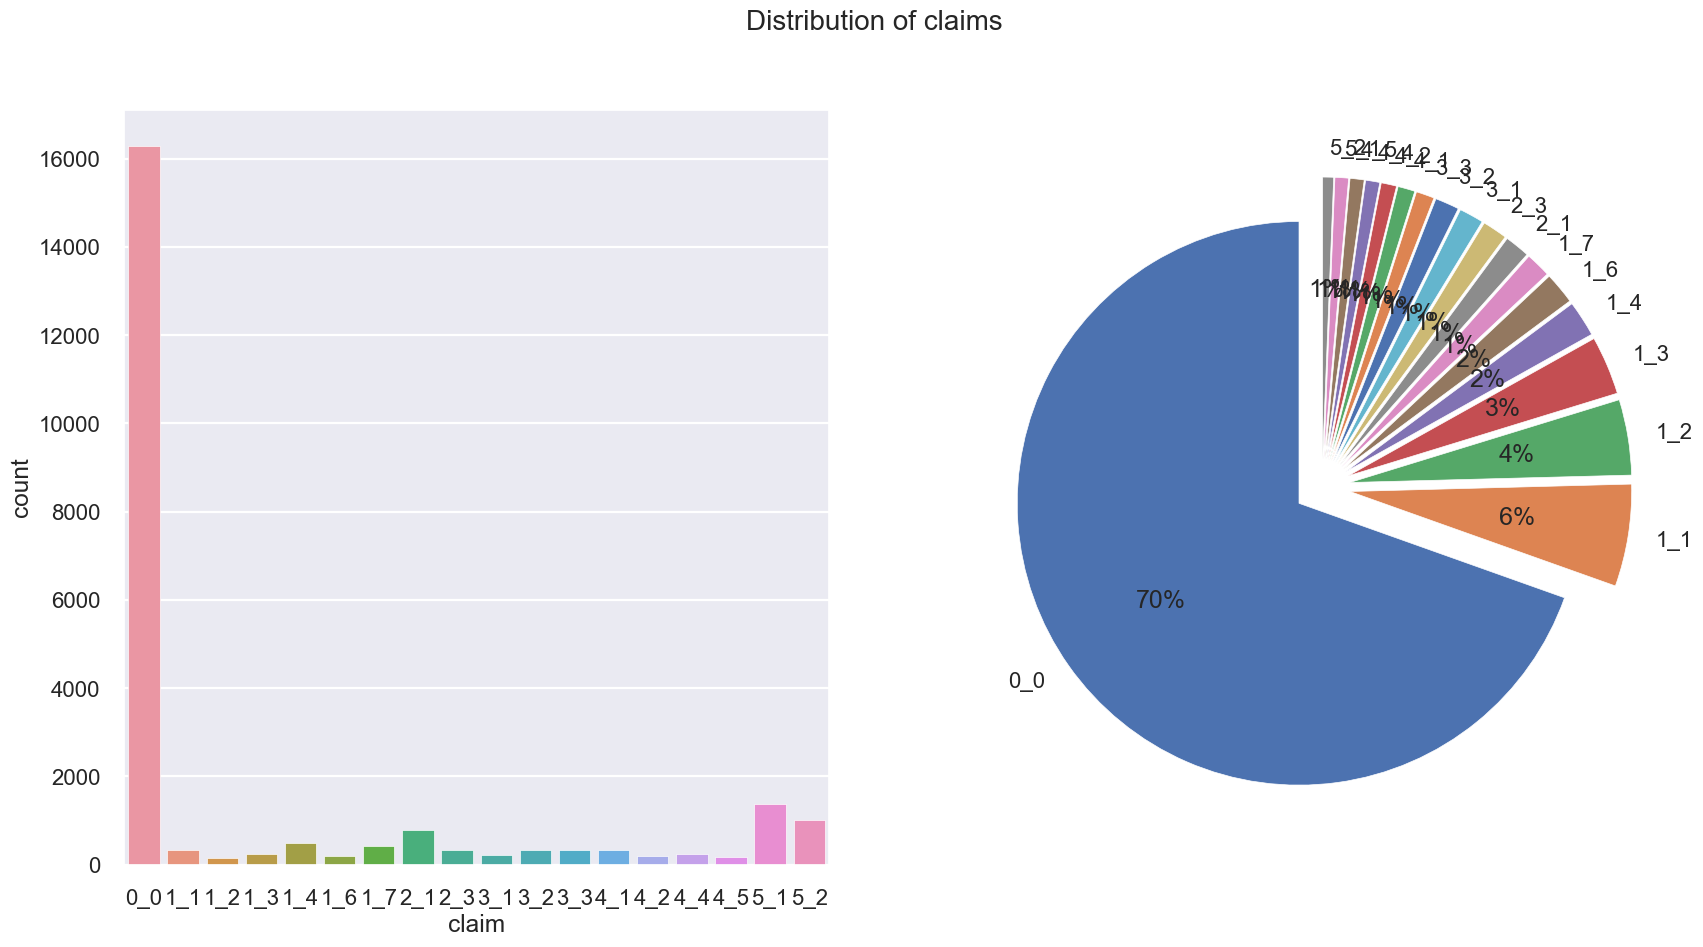

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10), dpi=100)

sns.countplot(eda["claim"], ax=axes[0])
#labels = list(sentiment_num2name.values())
axes[1].pie(eda["claim"].value_counts(),
            labels=labels,
            autopct="%1.0f%%",
            startangle=90,
            explode=tuple([0.1] * len(labels)))

fig.suptitle("Distribution of claims", fontsize=20)
plt.show()

In [11]:
def cleaner(tweet):
    
    
    to_del = [
        r"@[\w]*",  # strip account mentions
        r"^RT[\s]+",
        r"https?:\/\/.*[\r\n]*",  # strip URLs
        #r"#\w*",  # strip hashtags
        r"&amp"
        r"[,.;':@#?!\&/$]+\ *",
        r"\d+",  # delete numeric values
        r"U+FFFD",  # remove the "character note present" diamond
        r"[^A-Za-z0-9]+"
    ]
    for key in to_del:
        tweet = re.sub(key, " ", tweet)
    
    tweet = tweet.lower()
    # strip punctuation and special characters
    #tweet = re.sub(r"[,.;':@#?!\&/$]+\ *", " ", tweet)
    # strip excess white-space
    tweet = re.sub(r"\s\s+", " ", tweet)
    
    return tweet.lstrip(" ")

eda["text"] = eda["text"].apply(cleaner)
eda.head()

text  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                 what do you do if you are a global warming alarmist and real world temperatures do not warm as much as your climate model predicted    
1                                                                                                                                                                                                                                                                                                                                                                                                                    a sun blocking volcanic aerosols component to explain the sudden but temporary cooling of global sea surface temperatures that are caused by catastrophic volcanic eruptions and    
2                                                                                                                                                                                                                                                                                                                                                      now i am very interested in the amo since it strongly influences atlantic hurricanes arctic sea ice and greenland climate we are already seeing a recovery of the atlantic sector of the arctic sea ice and some hints of cooling in greenland    
3  dr christy addressed recent challenges to the satellite data one paper claimed to show that the satellite data actually show warming the author however used only percent on the satellite data the data with the least coverage and the greatest error each attack of the satellite data has disregarded the fact that this record is independently validated by a percent correspondence with the radiosonde balloon data these same scientists seem to put a lot of credence in surface temperature data that only cover percent of the globe nearly all of which is in the northern hemisphere    
4                                                                                                                                                                                                                                                                                                             after a brief protest from massachusetts republicans in their state senate the commonwealth is on the verge of changing its law to allow gov deval patrick d to appoint an interim senator until the special election to fill the late sen edward kennedy s seat can be held in january    

  claim super_claim sub_claim  
0   5_1           5         1  
1   0_0           0         0  
2   1_1           1         1  
3   0_0           0         0  
4   0_0           0         0

In [12]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords, wordnet 

In [13]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

def lemmatizer(df):
    df["length"] = df["text"].str.len()
    df["tokenized"] = df["text"].apply(word_tokenize)
    df["parts-of-speech"] = df["tokenized"].apply(nltk.tag.pos_tag)
    
    def str2wordnet(tag):
        conversion = {"J": wordnet.ADJ, "V": wordnet.VERB, "N": wordnet.NOUN, "R": wordnet.ADV}
        try:
            return conversion[tag[0].upper()]
        except KeyError:
            return wordnet.NOUN
    
    wnl = WordNetLemmatizer()
    df["parts-of-speech"] = df["parts-of-speech"].apply(
        lambda tokens: [(word, str2wordnet(tag)) for word, tag in tokens]
    )
    df["lemmatized"] = df["parts-of-speech"].apply(
        lambda tokens: [wnl.lemmatize(word, tag) for word, tag in tokens]
    )
    df["lemmatized"] = df["lemmatized"].apply(lambda tokens: " ".join(map(str, tokens)))
    
    return df



[nltk_data] Downloading package punkt to /Users/Ish/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/Ish/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/Ish/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [14]:
eda = lemmatizer(eda)
eda.head()

text  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                 what do you do if you are a global warming alarmist and real world temperatures do not warm as much as your climate model predicted    
1                                                                                                                                                                                                                                                                                                                                                                                                                    a sun blocking volcanic aerosols component to explain the sudden but temporary cooling of global sea surface temperatures that are caused by catastrophic volcanic eruptions and    
2                                                                                                                                                                                                                                                                                                                                                      now i am very interested in the amo since it strongly influences atlantic hurricanes arctic sea ice and greenland climate we are already seeing a recovery of the atlantic sector of the arctic sea ice and some hints of cooling in greenland    
3  dr christy addressed recent challenges to the satellite data one paper claimed to show that the satellite data actually show warming the author however used only percent on the satellite data the data with the least coverage and the greatest error each attack of the satellite data has disregarded the fact that this record is independently validated by a percent correspondence with the radiosonde balloon data these same scientists seem to put a lot of credence in surface temperature data that only cover percent of the globe nearly all of which is in the northern hemisphere    
4                                                                                                                                                                                                                                                                                                             after a brief protest from massachusetts republicans in their state senate the commonwealth is on the verge of changing its law to allow gov deval patrick d to appoint an interim senator until the special election to fill the late sen edward kennedy s seat can be held in january    

  claim super_claim sub_claim  length  \
0   5_1           5         1     132   
1   0_0           0         0     177   
2   1_1           1         1     239   
3   0_0           0         0     579   
4   0_0           0         0     280   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             tokenized  \
0                                                                                                                                   

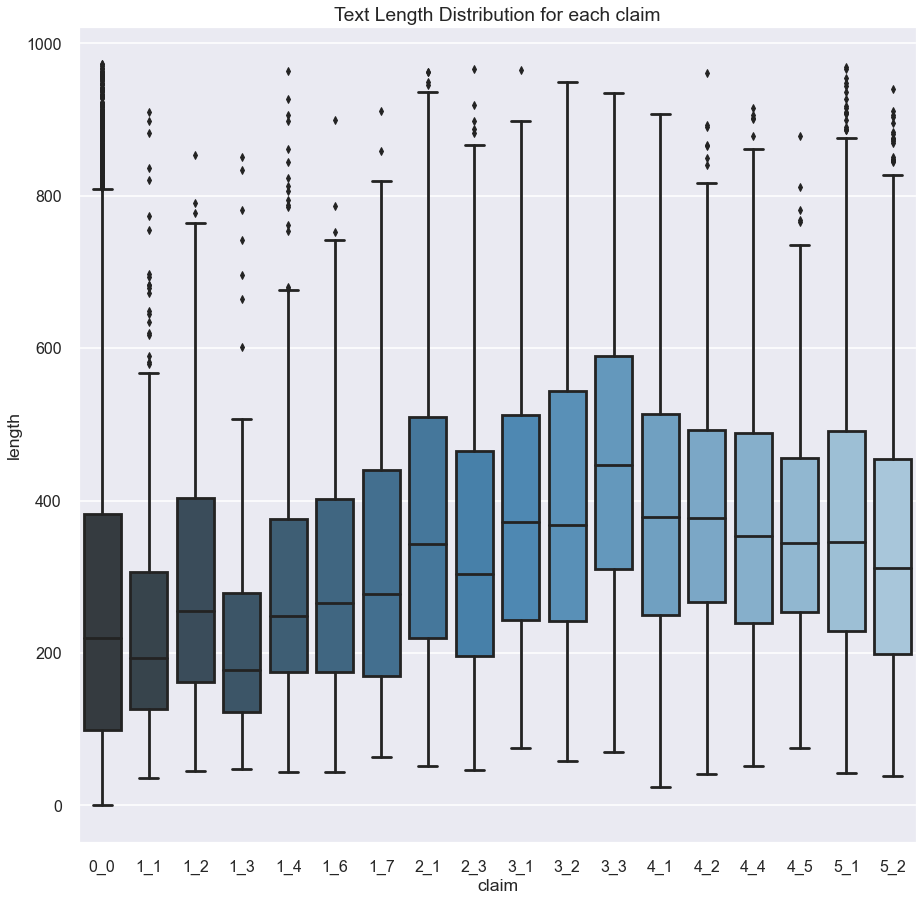

In [15]:
plt.figure(figsize=(15, 15))
sns.boxplot(x="claim", y="length", data=eda, palette=("Blues_d"))
plt.title("Text Length Distribution for each claim")
plt.show()

In [16]:
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer

frequency = {}

by_sentiment = eda.groupby("claim")
for sentiment, group in tqdm(by_sentiment):
    cv = CountVectorizer(stop_words="english")
    words = cv.fit_transform(group["lemmatized"])
    
    n_words = words.sum(axis=0)
    word_freq = [(word, n_words[0, idx]) for word, idx in cv.vocabulary_.items()]
    word_freq = sorted(word_freq, key=lambda x: x[1], reverse=True)
    
    freq = pd.DataFrame(word_freq, columns=["word", "freq"])
    
    frequency[sentiment] = freq.head(n=25)

to_view = pd.concat(frequency, axis=1).head(n=25)
display(to_view)

100%|██████████| 18/18 [00:01<00:00, 15.07it/s]


0_0                1_1               1_2               1_3       \
           word  freq         word freq         word freq         word freq   
0       climate  3261          ice  565         year  118         cold  154   
1        change  2225          sea  274       global   88       record  119   
2          year  2070       arctic  171          ice   73         snow  111   
3        global  2065         year  171  temperature   70  temperature  111   
4        energy  1934       extent  127      cooling   69         year   94   
5           say  1793    antarctic  113          age   66       winter   89   
6           new  1602       record   98         cool   58       degree   71   
7          make  1532         high   73        cycle   48       global   57   
8           use  1405     increase   72        solar   46      warming   39   
9         state  1384   antarctica   71      climate   40      weather   37   
10         time  1300         melt   70         warm   37      average   33   
11     emission  1165         area   60       period   36       normal   33   
12  temperature  1145       global   57        earth   35        month   32   
13        world  1125       summer   48    scientist   34     snowfall   30   
14      warming  1109         warm   45         cold   33          day   30   
15       policy  1083  temperature   44        trend   32     december   29   
16       people  1022        trend   43     activity   29          say   28   
17      science  1003    satellite   42      warming   27          low   27   
18   government   988      average   41      century   27         inch   27   
19       carbon   952         data   41          sun   26         warm   26   
20         like   936      glacier   38       decade   26         high   26   
21          gas   915        sheet   38       little   25         time   25   
22       report   912       normal   37          new   24       freeze   23   
23        power   894        level   37      sunspot   24      coldest   22   
24         warm   862      climate   36          say   24      january   20   

            1_4       ...          4_2               4_4               4_5  \
           word freq  ...         word freq         word freq         word   
0   temperature  420  ...     emission  164         wind  282          gas   
1        global  406  ...      climate  104       energy  175          oil   
2          year  376  ...       global   92        power  152       energy   
3          warm  301  ...       carbon   84        solar  111      natural   
4       warming  250  ...       energy   84  electricity  104        shale   
5       climate  162  ...        china   55         cost   83         coal   
6         trend  143  ...       reduce   54        plant   67         year   
7        decade  107  ...        world   50      turbine   61         fuel   
8          rise  101  ...       policy   50         fuel   58        power   
9        period  100  ...      country   47          gas   56        world   
10     increase   99  ...       change   46     increase   53      reserve   
11       change   91  ...    reduction   45      produce   52   production   
12      surface   90  ...       degree   43    renewable   47          new   
13         data   86  ...          gas   38         need   47      billion   
14        pause   83  ...         cost   37         coal   47      million   
15         cool   77  ...        kyoto   35     emission   44     increase   
16          say   67  ...  temperature   34         year   42      america   
17      century   67  ...      percent   33       demand   39        state   
18         past   61  ...      warming   31          use   37       barrel   
19        month   61  ...         year   31     generate   37      produce   
20       record   56  ...      dioxide   29     capacity   37        price   
21      average   54  ...        power   29        green   36       supply   
22    

100%|██████████| 18/18 [00:02<00:00,  7.34it/s]


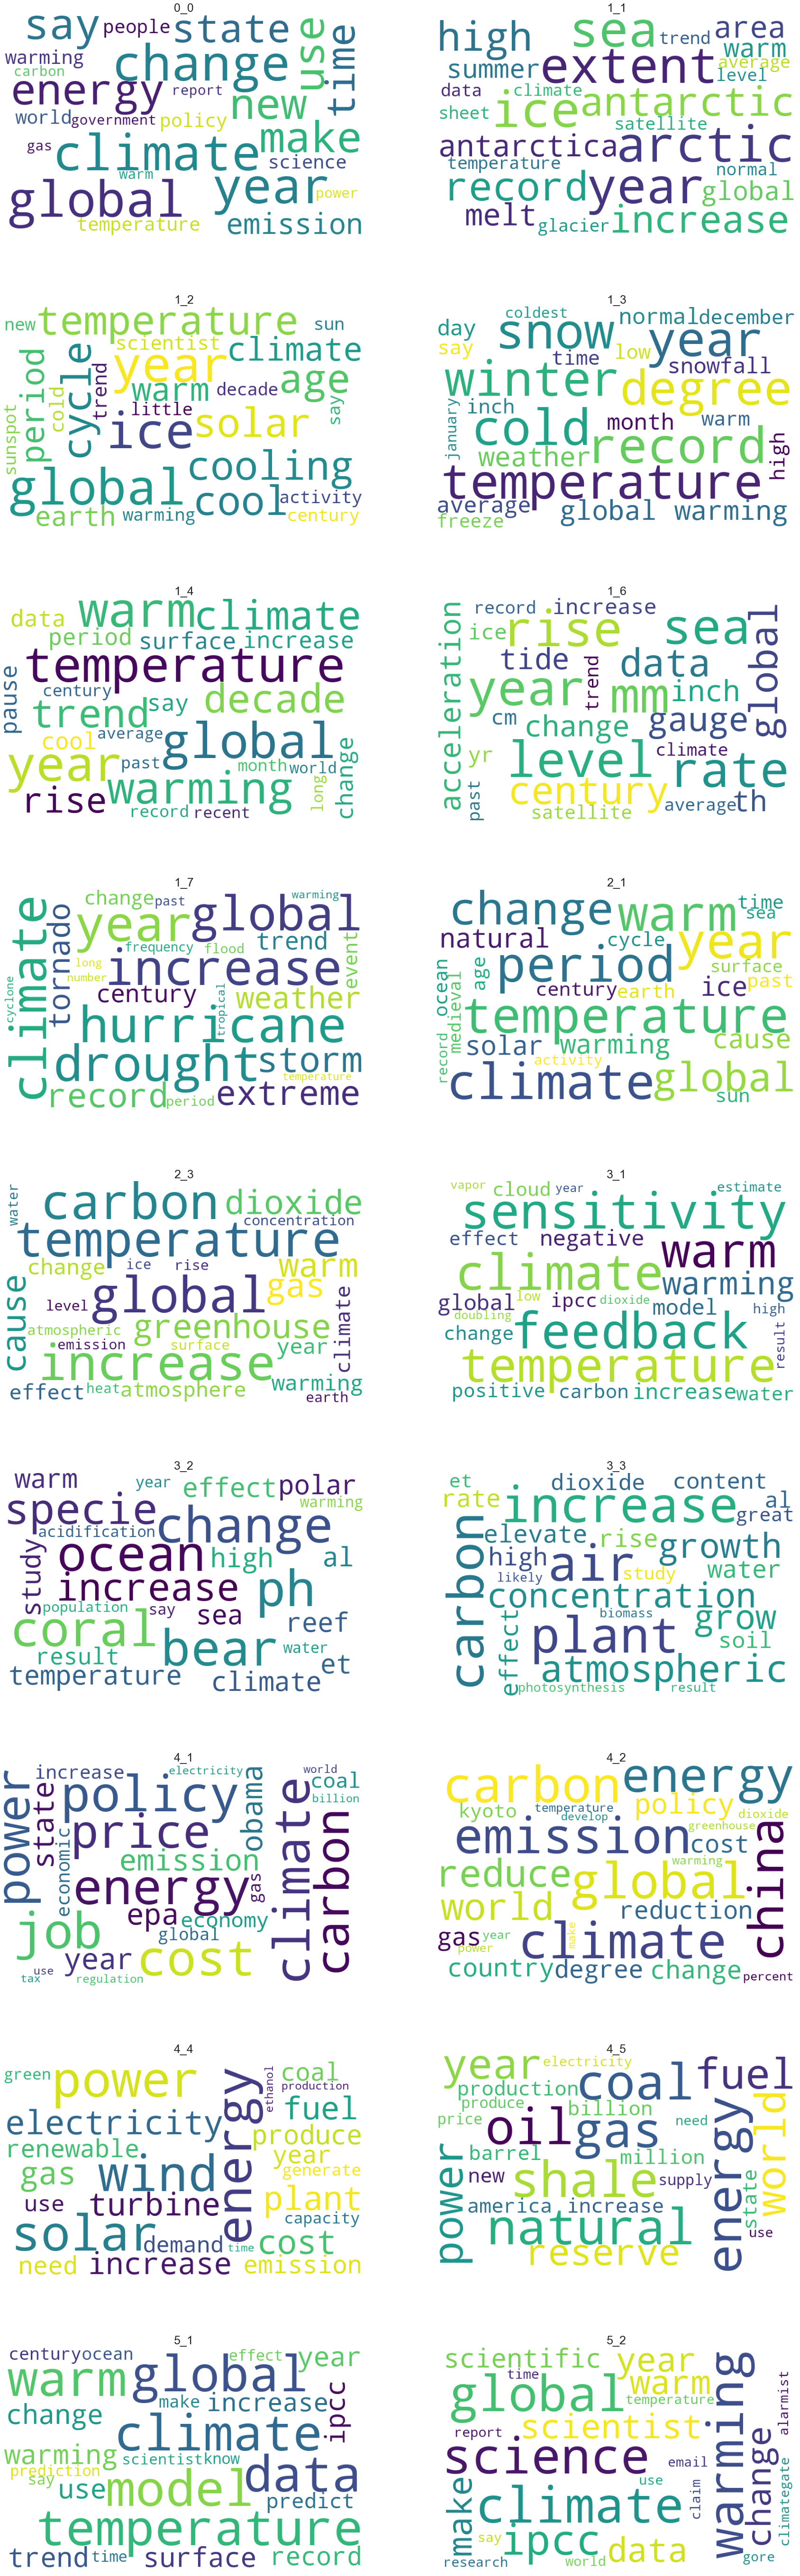

In [17]:
words = {sentiment: " ".join(frequency[sentiment]["word"].values) for sentiment in labels}

from wordcloud import WordCloud

wordclouds = {}
for sentiment in tqdm(labels):
    wordclouds[sentiment] = WordCloud(
        width=800, height=500, 
        max_font_size=110, background_color="white"
    ).generate(words[sentiment])
    
fig, axes = plt.subplots(9, 2, figsize=(30, 100))
counter = 0

for sentiment, wordcloud in wordclouds.items():
    axes[counter // 2, counter % 2].imshow(wordcloud)
    axes[counter // 2, counter % 2].set_title(sentiment, fontsize=25)
    counter += 1
    
for ax in fig.axes:
    plt.sca(ax)
    plt.axis("off")

plt.show()

In [18]:
X_train = train_df["text"]
y_train = train_df["claim"]
X_valid = valid_df["text"]
y_valid = valid_df["claim"]

tfidf = TfidfVectorizer()
tfidf.fit_transform(X_train)

<23436x39975 sparse matrix of type '<class 'numpy.float64'>'
	with 895520 stored elements in Compressed Sparse Row format>

In [19]:
import wandb
wandb.login()

# Name your wandb project
WANDB_PROJECT = 'aiforgood_twitter'
# Start a wandb run and add any additional info you'd like to the config  
run = wandb.init(project='aiforgood_twitter', 
                 config={'wandb_nb':'twitter'},
                 name='cards_data',
                 notes='EDA of cards data'
                ) 

wandb: Currently logged in as: ishgirwan (use `wandb login --relogin` to force relogin)


In [20]:
def train(tfidf, model, train_data, train_labels, test_data):
    model.fit(tfidf.transform(train_data), train_labels)
    preds = model.predict(tfidf.transform(test_data))
    probs = model.predict_proba(tfidf.transform(test_data))
    return preds, probs


In [21]:
def train_and_grade(model_name, tfidf, model, train_data, train_labels, test_data, test_labels):
    preds, probs = train(tfidf, model, train_data, train_labels, test_data)
    test_labels = test_labels.to_numpy()
    grade(model_name, model, preds, probs, test_labels)

In [22]:
def grade(model_name, model, preds, probs, test_labels):
    
    classification_report = wandb.sklearn.metrics.classification_report(test_labels, preds)
    print(classification_report)
    wandb.log({model_name + "_"+'classification_report': classification_report})
    cm = confusion_matrix(test_labels, preds)
    cm_normd = cm / cm.sum(axis=1).reshape(-1, 1)


    wandb.log({model_name + "_"+"pr_curve" : wandb.plot.pr_curve(
                                                        y_true=test_labels, 
                                                        y_probas=probs,
                                                        labels=model.classes_)})
    wandb.log({model_name + "_"+"roc" : wandb.plot.roc_curve(
                                                        y_true=test_labels, 
                                                        y_probas=probs,
                                                        labels=model.classes_)})

    # Confusion Matrix
    wandb.sklearn.plot_confusion_matrix(y_true=test_labels, 
                                        y_pred=preds, 
                                        labels=model.classes_,
                                        title=model_name + "_"+"Confusion matrix",
                                        normalize=True)
    heatmap_kwargs = dict(
        cmap="YlGnBu",
        xticklabels=model.classes_,
        yticklabels=model.classes_,
        vmin=0.,
        vmax=1.,
        annot=True,
        annot_kws={"size": 10},
    )
    
    sns.heatmap(cm_normd, **heatmap_kwargs)
    
    plt.title(f"{model.__class__.__name__} Classification")
    plt.ylabel("Ground-truth labels")
    plt.xlabel("Predicted labels")
    plt.plot()


              precision    recall  f1-score   support

         0_0       0.97      0.69      0.80      1812
         1_1       0.70      0.89      0.79        37
         1_2       0.33      0.44      0.38        16
         1_3       0.49      0.84      0.62        25
         1_4       0.48      0.74      0.58        54
         1_6       0.57      0.95      0.71        21
         1_7       0.61      0.85      0.71        47
         2_1       0.49      0.73      0.58        88
         2_3       0.44      0.71      0.54        38
         3_1       0.52      0.65      0.58        23
         3_2       0.62      0.82      0.70        38
         3_3       0.87      0.94      0.91        36
         4_1       0.23      0.64      0.34        36
         4_2       0.20      0.62      0.30        21
         4_4       0.31      0.81      0.45        27
         4_5       0.27      0.70      0.39        20
         5_1       0.54      0.70      0.61       153
         5_2       0.33    

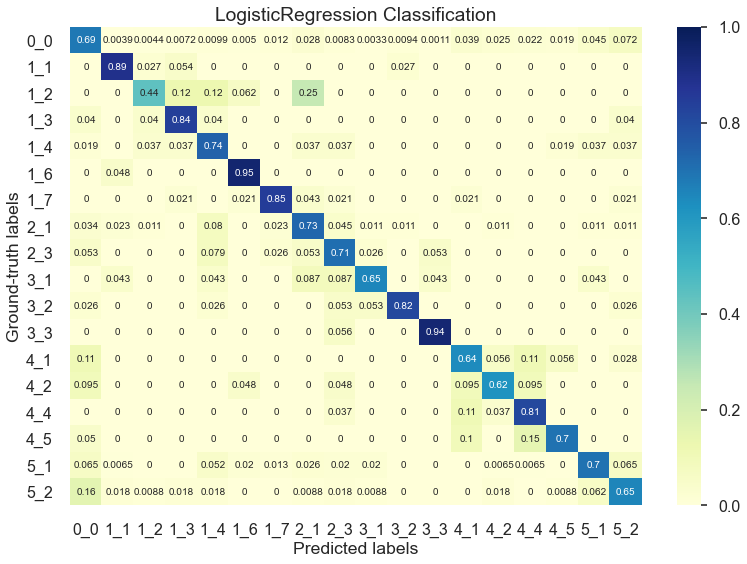

In [23]:
logreg = LogisticRegression(C=1, class_weight="balanced", max_iter=1000)
train_and_grade('Logistic_Regression', tfidf, logreg, X_train, y_train, X_valid, y_valid)

In [24]:
run.finish()